### Import relevant Libraries


In [62]:

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from transformers import ViTForImageClassification

## Loading the test Dataset

In [53]:
dataset = torchvision.datasets.ImageFolder(
    root="MINIMias-mod/Test",
    transform=transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize(224),  # Resize to ViT input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),# Normalize for ViT
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat for 3 channels
    ])
)

In [54]:
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [55]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


### Applying Data Augmentation to the training set

In [56]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

dataset = torchvision.datasets.ImageFolder(
    root="MINIMias-mod/Train",
    transform=transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize(224),  # Resize to ViT input size
        transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
        transforms.RandomRotation(45),  # Randomly rotate the image by up to 45 degrees  # Adjust brightness, contrast, saturation, and hue
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # Randomly crop and resize the image
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize for ViT
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat for 3 channels
    ])
)

In [57]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
# kfold = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

In [58]:

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_channels=3,ignore_mismatched_sizes=True)  # Specify num_channels here
model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

## Training cell

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 75
best_val_accuracy = 0

## training on all 5 folds
for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and test sets
    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, test_indices)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)



    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print training statistics after each batch
            train_running_loss += loss.item() * images.size(0)  # Accumulate loss for the epoch
            _, predicted = torch.max(outputs.logits, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Training Loss: {loss.item():.4f}, Training Accuracy: {100 * train_correct / train_total:.2f}%")

        model.eval()
        val_correct = 0
        val_total = 0
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.logits, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
            for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)

              outputs = model(images)
              _, predicted = torch.max(outputs.logits, 1)

              true_labels.extend(labels.cpu().numpy())
              predicted_labels.extend(predicted.cpu().numpy())


            val_accuracy = 100 * val_correct / val_total
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%")

            test_accuracy = accuracy_score(true_labels, predicted_labels)
            # print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



            if test_accuracy > best_val_accuracy:
                best_val_accuracy = test_accuracy
                best_model_state = model.state_dict()
                torch.save(model.state_dict(), 'SIPbest.pt')
                print("saved best model with accuracy: ", best_val_accuracy)

model.load_state_dict(best_model_state)




## Testing cell

Test Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20

Confusion Matrix:


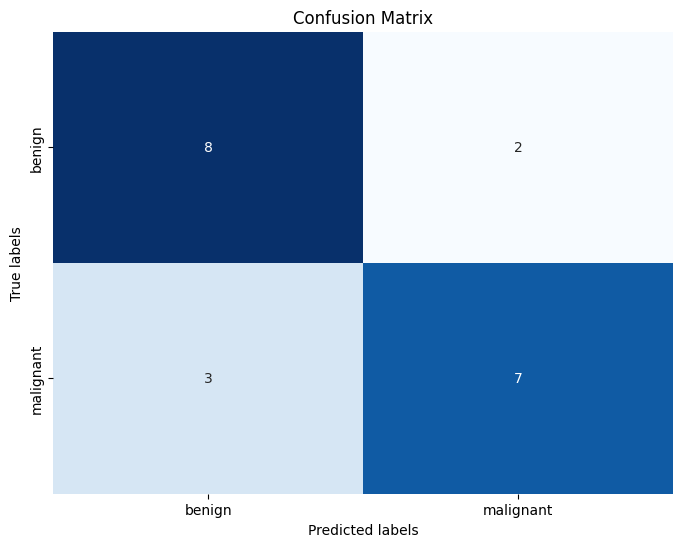

In [64]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# Load the model checkpoint
checkpoint = torch.load("SIPbest.pt")
model.load_state_dict(checkpoint)
# model.load_state_dict(best_model_state)
model.eval()

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Display classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Display confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

import seaborn as sns
class_labels = ['benign', 'malignant']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
